# Description

This project aims to build and understand collaborative filters with applications in movie recommendation systems. By [definition](https://en.wikipedia.org/wiki/Collaborative_filtering):

**Collaborative filtering is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating)**

Through this project, we also get to understand the idea of *embedding* that appears frequently in NLP context. This idea is very important as it enables us continue exploring *word embedding* in various deep learning problems for NLP. Lastly, as we will have multiple inputs (users and movies), we will explore Keras's functional API which allows us to merge multiple inputs easier than Sequential API.

# Data preparation

We will use the movielen big [dataset](http://files.grouplens.org/datasets/movielens/ml-20m.zip). We also use movielens's small [dataset](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip) for quick protyping and experimenting changes.

## 1.1. Get to know the dataset

The downloaded dataset contains several.csv files of which we are interested in movies, users, and rating data from 2 following files:

- rating.csv contains all rating of users ( stored as userId) for movies (stored as movieId). 
- movie.csv contains movie names corresponding with movieId

### Basic visual and statistics

In [1]:
import numpy as np
import pandas as pd

#path = "ml-20m/" # Large datasets
path = "ml-latest-small/" # Small dataset
model_path = path + 'models/' # Directory to store trained models
batch_size=64 # Batch size for stoschatic gradient descent optimization 

In [3]:
# Load rating data 
ratings = pd.read_csv(path+'ratings.csv')
# print some data rows
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [4]:
# Data length
len(ratings)

100004

In [5]:
# Get the list of userID and list of movieID
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [6]:
# Print number of users and number of movies rated
nb_user = len(users)
nb_movie =  len(movies)
print "number of users: {} \nnumber of movies {}".format(nb_user,nb_movie)
print "rating values: {}".format(ratings.rating.unique())

number of users: 671 
number of movies 9066
rating values: [ 2.5  3.   2.   4.   3.5  1.   5.   4.5  1.5  0.5]


In [7]:
# Count number of rates for every user.
# Sort the list from users who review most of movies to user who review very few movies
user_nb_rate=ratings['rating'].groupby(ratings['userId']).count().sort_values(ascending=False)
# Top 10 user that rate most of the movies
top_rate_user = user_nb_rate[0:10]
top_rate_user

userId
547    2391
564    1868
624    1735
15     1700
73     1610
452    1340
468    1291
380    1063
311    1019
30     1011
Name: rating, dtype: int64

Well, user 547 really watched a lot of movies...

Now, let's do the same for movies

In [8]:
# Count number of rates for every user.
# Sort the list from users who review most of movies to user who review very few movies
movie_nb_rate=ratings['rating'].groupby(ratings['movieId']).count().sort_values(ascending=False)
# Top 10 movies that get the most ratings
top_rate_movie = movie_nb_rate[0:10]
top_rate_movie

movieId
356     341
296     324
318     311
593     304
260     291
480     274
2571    259
1       247
527     244
589     237
Name: rating, dtype: int64

In [9]:
# Filter the 10 top users from the main dataframe
top_rate = ratings.join(top_rate_user, rsuffix='_r', how='inner', on='userId')
# Filter top 10 movies from the list of ratings by top 10 users
top_rate = top_rate.join(top_rate_movie, rsuffix = '_r', how = 'inner', on = 'movieId')

# Plot the table of top rate movies vs. top rate users
pd.crosstab(top_rate.userId, top_rate.movieId, top_rate.rating, aggfunc=np.sum)

movieId,1,260,296,318,356,480,527,589,593,2571
userId,,,,,,,,,,
15,2.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0
30,4.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,3.0
73,5.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.5
311,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0
380,4.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,5.0
452,3.5,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,2.0
468,4.0,3.5,3.5,3.5,3.0,2.5,NaN,NaN,3.0,3.0
547,3.5,NaN,5.0,5.0,2.0,3.0,5.0,NaN,5.0,3.5
564,4.0,2.0,5.0,NaN,3.0,5.0,4.0,5.0,5.0,3.0


Similarly, let's plot bottom 15 users and botton 15 movies.

In [10]:
bottom_rate_user = user_nb_rate.tail(15)
bottom_rate_user

userId
604    20
319    20
583    20
484    20
337    20
76     20
540    20
399    20
35     20
438    20
444    20
445    20
448    20
498    20
1      20
Name: rating, dtype: int64

In [11]:
bottom_rate_movie = movie_nb_rate.tail(15)
bottom_rate_movie

movieId
26404     1
26409     1
26413     1
26487     1
26414     1
26422     1
26430     1
26435     1
26462     1
26464     1
26467     1
26471     1
26480     1
26485     1
163949    1
Name: rating, dtype: int64

In [12]:
# Filter the 15 top users from the main dataframe
bottom_rate = ratings.join(bottom_rate_user, rsuffix ='_r', how='inner', on='userId')
# Filter top 15 movies from the list of ratings by bottom 15 users
bottom_rate = bottom_rate.join(top_rate_movie, rsuffix = '_r', how = 'inner', on = 'movieId')
# Plot the table of top rate movies vs. bottom rate users
pd.crosstab(bottom_rate.userId, bottom_rate.movieId, bottom_rate.rating, aggfunc=np.sum)

movieId,1,260,296,318,356,480,527,589,593,2571
userId,,,,,,,,,,
319,NaN,NaN,NaN,NaN,3.0,4.0,NaN,3.0,4.0,NaN
337,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN
399,NaN,NaN,5.0,4.0,NaN,3.0,NaN,NaN,4.0,NaN
438,NaN,NaN,5.0,5.0,NaN,NaN,4.5,NaN,NaN,NaN
445,NaN,NaN,4.5,5.0,5.0,3.5,NaN,NaN,3.5,NaN
448,3.0,5.0,NaN,NaN,3.0,5.0,NaN,5.0,5.0,5.0
484,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
540,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
583,NaN,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN


### *** Data Exploration Summary ***

(small-data-set) We have 671 users and 9066 movies. There are totally 100004 ratings. Of course, there will be users who rate more movies than others users shown as NaN values in above table. Our job is to provide the *predictions* of rating for all the users for all the the movies that they didn't rate yet. The recommendation system will take those movies with high predicted ratings to recommend users that they should watch them.

## 1.2. Data Processing

To be convenient for maniplating data, we will do the following:

1. Map userID to list of integers from 0 to 670. Do similar map for movieID. These mappings are conveninent if we want to do one-hot encoder or later on, create embeddings for users and movies.

2. Split dataset to training roughly 80% and validation roungly 20%.

Let's get it moving.


In [13]:
# Create mapping userID to integers from 0 to 670, store as a dictionary. 
# Similarly, mapping movieID to integers from 0 to 9066.
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

In [14]:
# Apply the integer map to the userID in rating dataframe. Similarly, do the same for movieID.
ratings['userId'] = ratings['userId'].apply(lambda x: userid2idx[x])
ratings['movieId'] = ratings['movieId'].apply(lambda x: movieid2idx[x])

In [15]:
# random split approximately 80% of data for training, the rest is for validation
split = np.random.rand(len(ratings)) < 0.8
train = ratings[split]
valid = ratings[~split]

# Embeddings


The idea of embedding in collaborative filtering is as follows:

- In order to predict how a particular user will rate a particular movie, we will base on (1) rating data from other users on that movie and (2) rating data from that user on other movies.

- Therefore, we need to somehow capture all the information about a particular user and movie such as movie genres, actor or actress preference, sad or fun, heavilly conversative or quite, etc. But we do not have data on these features.

- So we encode each userID with a numeric-valued vector called latent factor. During learning process (training with a lot of data), this vector will be fine-tuned and store all the information about this particular user.

- Similarly, we store information about a particular movie in another numeric-valued vector with equal length with userID's (called factor length).

- If we want to make a prediction about particular userID on a particular movie, we combine information on both of their latent vectors. Depending how we model the combination (linear, neural net, conv net, etc), we will have different predictions.

In [16]:
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Reshape, merge, LSTM, Bidirectional
from keras.layers import TimeDistributed, Activation, SimpleRNN, GRU
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.regularizers import l2, activity_l2, l1, activity_l1
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils.layer_utils import layer_from_config
from keras.metrics import categorical_crossentropy, categorical_accuracy
from keras.layers.convolutional import *

Using Theano backend.


# 2.1. Linear model

The most basic embedding is a linear model where an output (rating) is produced by taking dot product between user embedding and movie embedding.



In [17]:
from keras.layers import Input, Embedding, Reshape, merge
from keras.regularizers import l2

# Number of embedding factor for each movieID and each userID
nb_factor =50

### 2.1.1. Create user embedding 

In [18]:
# User input data structure
user_input = Input(shape=(1,), dtype='int64', name='user_input')
# User embedding
user_emb = Embedding(nb_user, nb_factor, input_length=1, W_regularizer=l2(1e-4))(user_input)

### 2.1.2. Create movie embedding

In [19]:
# User input data structure
movie_input = Input(shape=(1,), dtype='int64', name='movie_input')
# User embedding
movie_emb = Embedding(nb_movie, nb_factor, input_length=1, W_regularizer=l2(1e-4))(movie_input)

### 2.1.3. Biases

Like every linear model, we need to add biases to capture the information about ... bias. There are people who like Brat Pitt over Tom Cruise (e.g., me) or like love movies over action movies. These biases to a particular movies or type of movies, or whatever in the movie are summurized into the bias terms. Each movie will get one bias value and so does each user.

**Note** It is a common practice to not regularize bias terms.

In [20]:
# Generate a user bias
user_bias =  Embedding(nb_user, 1, input_length = 1)(user_input)
user_bias = Flatten()(user_bias)

# Generate a movie bias
movie_bias = Embedding(nb_movie, 1, input_length =1)(movie_input)
movie_bias = Flatten()(movie_bias)

### 2.1.4. Building linear model

Since we have 2 separated input to our model: userID and movieID, using Keras's sequential API is not ideal because it is suited for only one input array. Luckily, Keras's functional API allows us to merge two input arrays pretty neat. In fact, we can do all the sequential modelling with functional API. 

Let's build the linear model with Keras's functional API.

In [21]:
# Learning rate
lr =0.001
# Building a linear model
inp = merge([user_emb, movie_emb], mode = 'dot')
inp = Flatten()(inp)
inp = merge([inp, user_bias], mode = 'sum')
inp = merge([inp, movie_bias], mode = 'sum')
model = Model([user_input, movie_input], inp)
model.compile(Adam(lr), loss = 'mse')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_input (InputLayer)          (None, 1)             0                                            
____________________________________________________________________________________________________
movie_input (InputLayer)         (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 50)         33550       user_input[0][0]                 
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 50)         453300      movie_input[0][0]                
___________________________________________________________________________________________

### 2.1.4. Training

We start with a learning rate of 0.01

In [22]:
model.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=5, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 80114 samples, validate on 19890 samples
Epoch 1/5
80114/80114 [==============================] - 14s - loss: 8.9817 - val_loss: 3.2452
Epoch 2/5
80114/80114 [==============================] - 18s - loss: 2.5944 - val_loss: 1.6818
Epoch 3/5
80114/80114 [==============================] - 18s - loss: 1.9796 - val_loss: 1.3794
Epoch 4/5
80114/80114 [==============================] - 18s - loss: 1.8152 - val_loss: 1.2643
Epoch 5/5
80114/80114 [==============================] - 18s - loss: 1.7226 - val_loss: 1.1996


Let's decrease the learning rate to 0.001, run for another 5 epoches to closely watch for overfitting.

In [23]:
model.optimizer.lr = 0.001
model.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=5, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 80114 samples, validate on 19890 samples
Epoch 1/5
80114/80114 [==============================] - 18s - loss: 1.6445 - val_loss: 1.1634
Epoch 2/5
80114/80114 [==============================] - 18s - loss: 1.5713 - val_loss: 1.1354
Epoch 3/5
80114/80114 [==============================] - 18s - loss: 1.5010 - val_loss: 1.1010
Epoch 4/5
80114/80114 [==============================] - 18s - loss: 1.4329 - val_loss: 1.0738
Epoch 5/5
80114/80114 [==============================] - 18s - loss: 1.3656 - val_loss: 1.0502


The validation loss is still less than training loss. We can run few more epoches. Let's do another 3.

In [24]:
model.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=3, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 80114 samples, validate on 19890 samples
Epoch 1/3
80114/80114 [==============================] - 18s - loss: 1.3003 - val_loss: 1.0235
Epoch 2/3
80114/80114 [==============================] - 19s - loss: 1.2383 - val_loss: 1.0018
Epoch 3/3
80114/80114 [==============================] - 18s - loss: 1.1787 - val_loss: 0.9771


Still good to go for more epoches ...

In [25]:
model.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=3, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 80114 samples, validate on 19890 samples
Epoch 1/3
80114/80114 [==============================] - 18s - loss: 1.1215 - val_loss: 0.9602
Epoch 2/3
80114/80114 [==============================] - 19s - loss: 1.0665 - val_loss: 0.9401
Epoch 3/3
80114/80114 [==============================] - 19s - loss: 1.0142 - val_loss: 0.9233


Very close, maybe two more epoch

In [26]:
model.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=1, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 80114 samples, validate on 19890 samples
Epoch 1/1
80114/80114 [==============================] - 19s - loss: 0.9663 - val_loss: 0.9050


In [27]:
model.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=1, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 80114 samples, validate on 19890 samples
Epoch 1/1
80114/80114 [==============================] - 19s - loss: 0.9193 - val_loss: 0.8915


In [28]:
model.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=1, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 80114 samples, validate on 19890 samples
Epoch 1/1
80114/80114 [==============================] - 19s - loss: 0.8766 - val_loss: 0.8774


We are slightly overfitting. But it is sill a good model. Let's save the model and use it to make some predictions.

### 2.1.5. Save model


In [29]:
model.save_weights('movie_pred.h5')

In [30]:
# Load model
model.load_weights('movie_pred.h5')

## 2.2. Simple Neural Net Model
Instead of linear model, we can construct a simple neural net. 

In [31]:
# User input data structure
user_input = Input(shape=(1,), dtype='int64', name='user_input')
# User embedding structure
user_emb = Embedding(nb_user, nb_factor, input_length=1, W_regularizer=l2(1e-4))(user_input)

# Movie input data structure
movie_input = Input(shape=(1,), dtype='int64', name='movie_input')
# movie embedding structure
movie_emb = Embedding(nb_movie, nb_factor, input_length=1, W_regularizer=l2(1e-4))(movie_input)


### 2.2.1 Build model

In [32]:
inp = merge([user_emb, movie_emb], mode ='concat')
inp = Flatten()(inp)
inp = Dropout(0.4)(inp)
inp = Dense(70, activation = 'relu')(inp)
inp = Dropout(0.7)(inp)
inp = Dense(1)(inp)
neural_model = Model([user_input, movie_input],inp)
neural_model.compile(Adam(0.001), loss = 'mse')
neural_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_input (InputLayer)          (None, 1)             0                                            
____________________________________________________________________________________________________
movie_input (InputLayer)         (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_5 (Embedding)          (None, 1, 50)         33550       user_input[0][0]                 
____________________________________________________________________________________________________
embedding_6 (Embedding)          (None, 1, 50)         453300      movie_input[0][0]                
___________________________________________________________________________________________

### 2.2.2. Train

In [33]:
neural_model.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=5, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 80114 samples, validate on 19890 samples
Epoch 1/5
80114/80114 [==============================] - 17s - loss: 2.1839 - val_loss: 0.8889
Epoch 2/5
80114/80114 [==============================] - 31s - loss: 1.3244 - val_loss: 0.8507
Epoch 3/5
80114/80114 [==============================] - 24s - loss: 1.1484 - val_loss: 0.8496
Epoch 4/5
80114/80114 [==============================] - 21s - loss: 1.0142 - val_loss: 0.8292
Epoch 5/5
80114/80114 [==============================] - 20s - loss: 0.9193 - val_loss: 0.8120


Let's do more epoches

In [34]:
model.fit([train.userId, train.movieId], train.rating, batch_size=64, nb_epoch=1, 
          validation_data=([valid.userId, valid.movieId], valid.rating))

Train on 80114 samples, validate on 19890 samples
Epoch 1/5
80114/80114 [==============================] - 19s - loss: 0.8362 - val_loss: 0.8635
Epoch 2/5
80114/80114 [==============================] - 19s - loss: 0.7988 - val_loss: 0.8529
Epoch 3/5
80114/80114 [==============================] - 20s - loss: 0.7648 - val_loss: 0.8436
Epoch 4/5
80114/80114 [==============================] - 20s - loss: 0.7336 - val_loss: 0.8349
Epoch 5/5
80114/80114 [==============================] - 20s - loss: 0.7053 - val_loss: 0.8278


In [35]:
# Save model
neural_model.save_weights('neural_movie_pred.h5')
# Load model
neural_model.load_weights('neural_movie_pred.h5')

# Interpret trained models

Let's visualize the information that stored in our movie embedding.

First, let's only consider top 1000 movies

In [53]:
toprate = ratings.groupby('movieId')['rating'].count()
topMovies = toprate.sort_values(ascending=False)[:3000]
topMovies = np.array(topMovies.index)

## Get the embedding matrix 

In [54]:
get_movie_emb = Model(movie_input, movie_emb)
movie_embedding = np.squeeze(get_movie_emb.predict([topMovies]))
movie_embedding.shape

(3000, 50)

As expected, for 1000 movies we considere, each movie is embedded with a latent vector of length 50. They are just a bunch of float numbers.

In [55]:
movie_embedding[0:5,0:10]

array([[ 0.03605637, -0.0689069 , -0.03956212, -0.01666591, -0.01608209,
         0.04261524, -0.0362253 , -0.03946941, -0.0589529 ,  0.01402908],
       [ 0.00625321,  0.01002394,  0.00594975,  0.01909552, -0.00935587,
         0.06336115,  0.04149859, -0.07168962, -0.07464209,  0.12879813],
       [ 0.0776244 ,  0.09118979, -0.12835416,  0.11166363, -0.1224141 ,
         0.10754803, -0.05943257, -0.07402156, -0.08008096,  0.15128721],
       [ 0.09457739,  0.03306984, -0.01850815,  0.14567937, -0.05728973,
         0.08761489,  0.05015401, -0.06993282, -0.11905899,  0.04434358],
       [-0.08949775,  0.01987002, -0.07763555,  0.06822521,  0.01082921,
         0.09059019, -0.09897146, -0.04258019, -0.05315145,  0.00515847]], dtype=float32)

## Dimension reduction and visualization

An embedding for 1000 movies is of the shape (1000x50) is hard to visuallize. To visualize such high dimensional data, we will reduce (approximate) the embedding data in a lower dimensional space of 3 (because we can plot with 3 dimensions). 

One way to do that is to use Singular Component Analysis (PCA), another ways is IsoMap. For this project we will use PCA.


First, we need to map movie names in the movies.csv dataset

In [56]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

## Principle Component Analysis
Apply PCA from skit-learn package.

In [57]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_embedding.T).components_

component1 = movie_pca[0]
component2 = movie_pca[1]
component3 = movie_pca[2]

## Plot principle components

First we need to change the default encoder to utf8 otherwise, Python will complain and throw an error:

 'ascii' codec can't decode byte 0xc3 in position 1: ordinal not in range

In [60]:
import sys
reload(sys)
sys.setdefaultencoding('utf8')

### Component 1 vs. Component 2

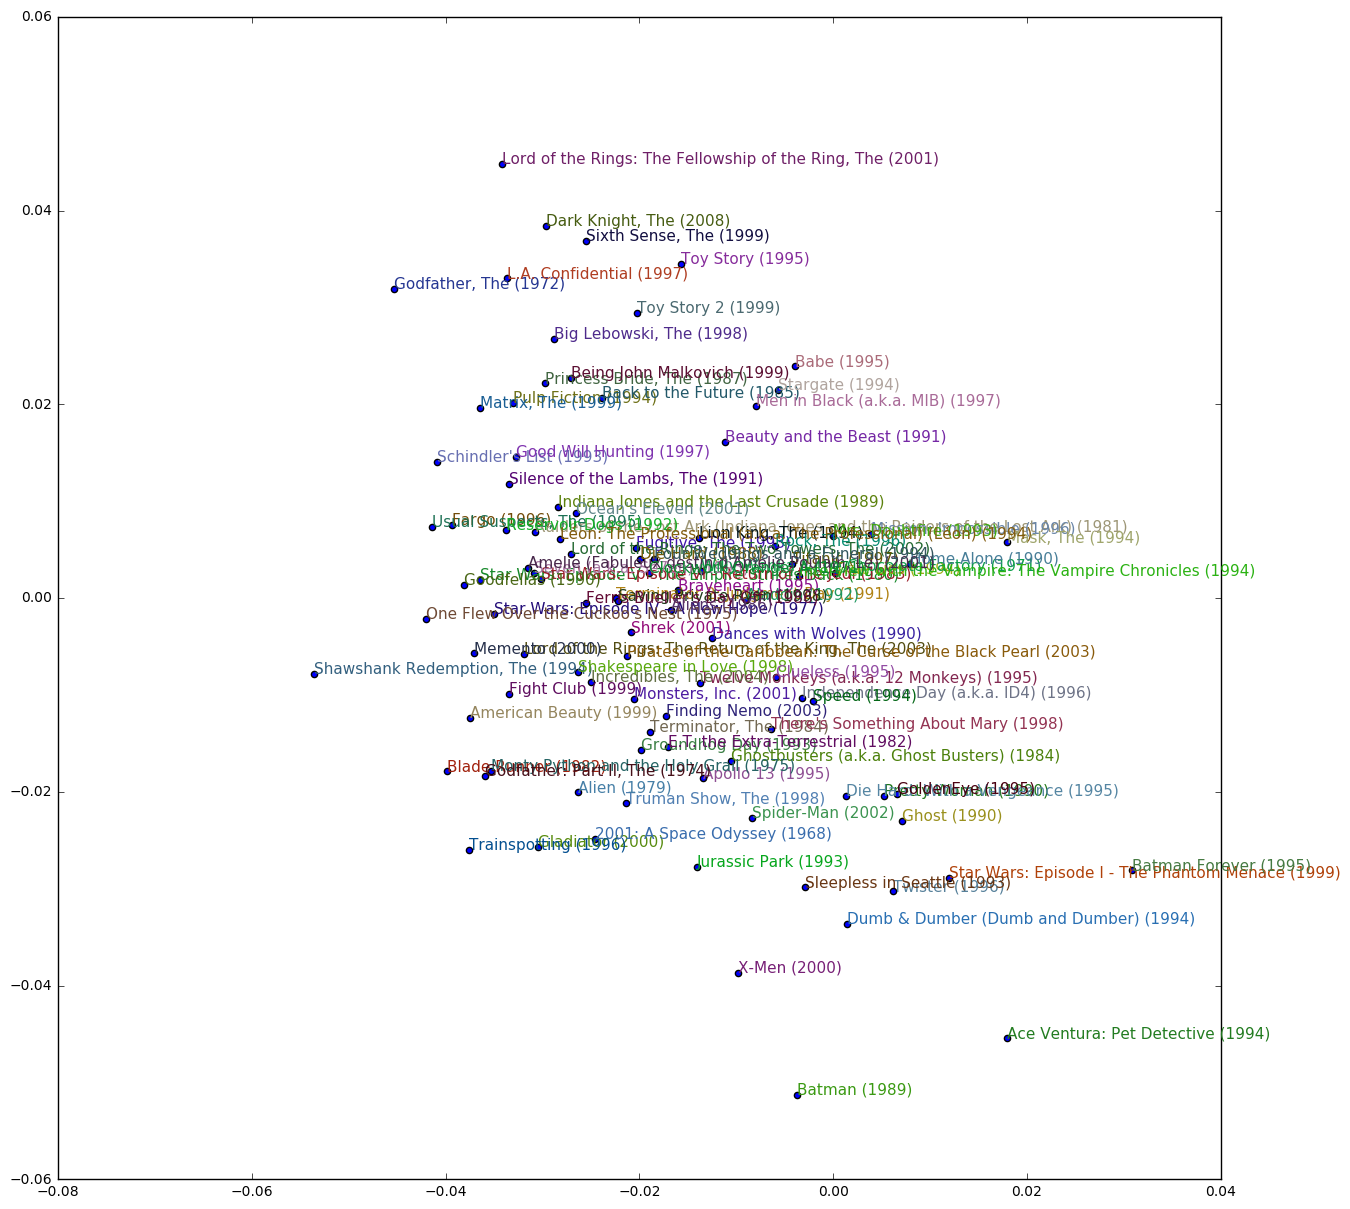

In [69]:
from matplotlib import pyplot as plt
%matplotlib inline

# Ploting first 2 pricipal components
start=1; end=100
X = component1[start:end]
Y = component2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Component 2 vs. Component 3

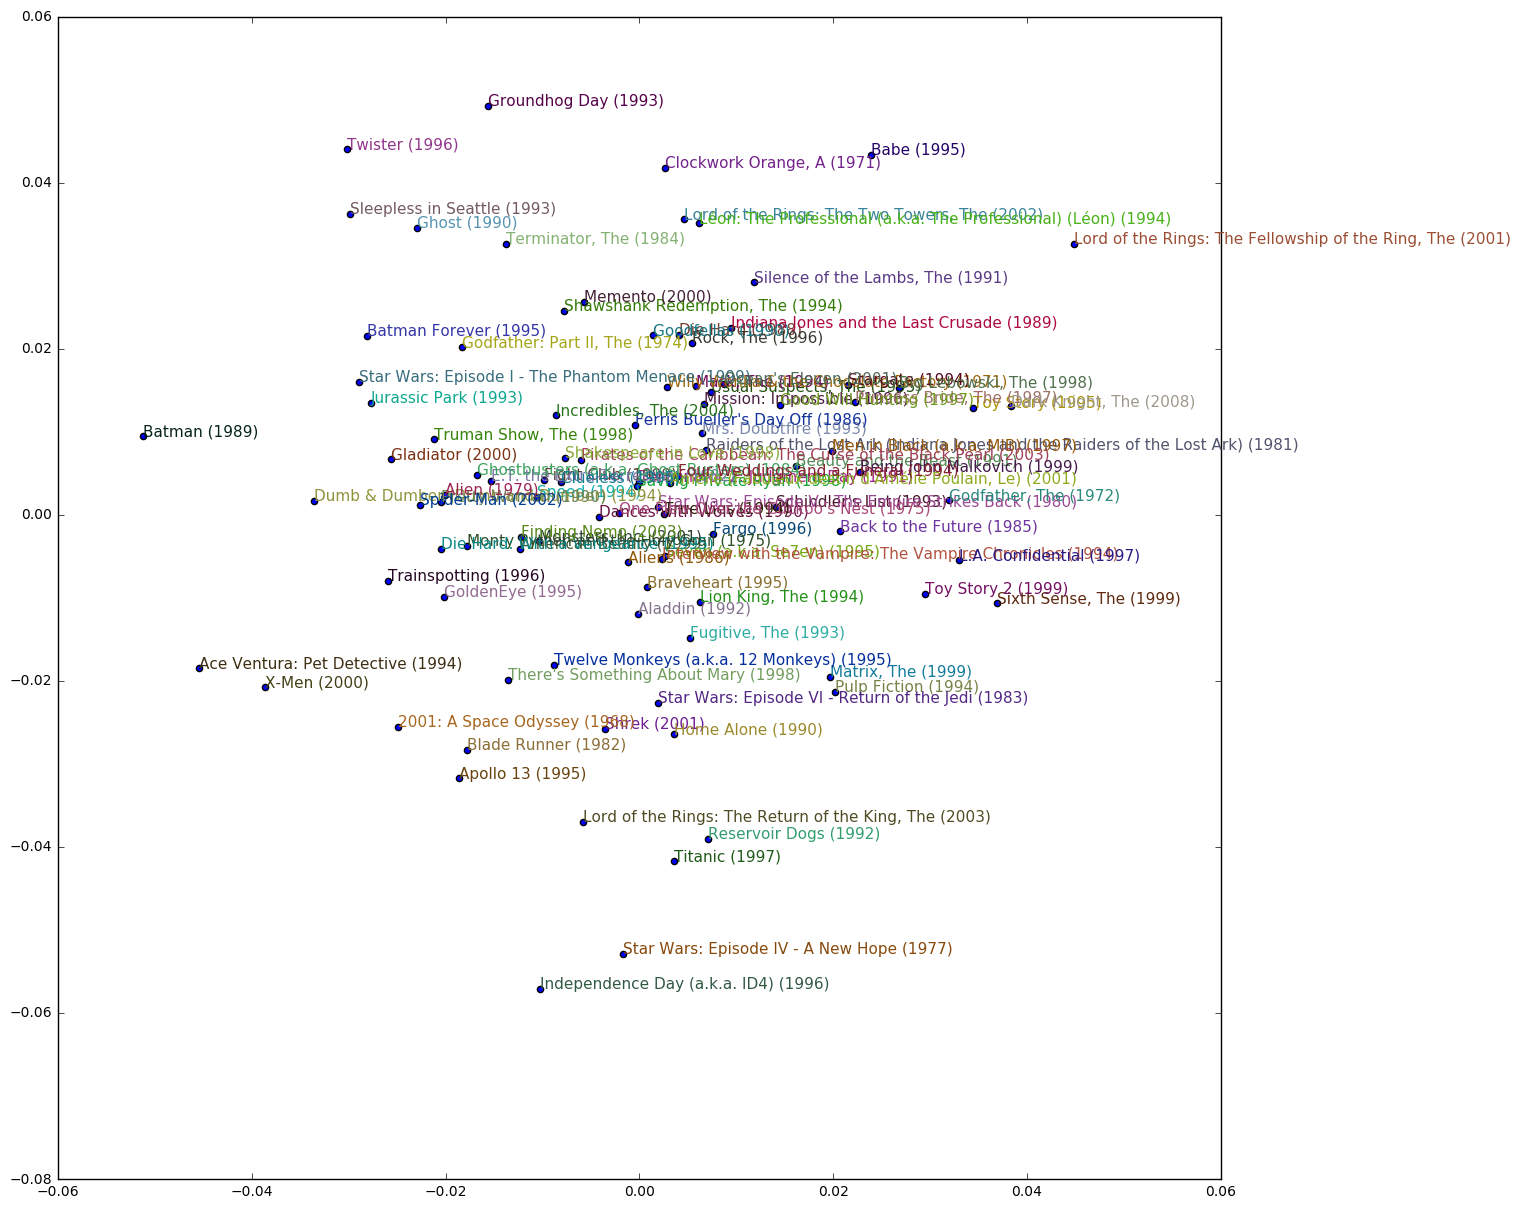

In [70]:
# Ploting last 2 pricipal components
start=1; end=100
X = component3[start:end]
Y = component2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()